# COMPAS Fairness Audit
This notebook audits racial bias in the COMPAS Recidivism Dataset using IBM’s AI Fairness 360 toolkit.

**Objectives:**
- Analyze bias metrics (e.g., disparate impact, false positive rate)
- Visualize disparities between racial groups
- Propose remediation strategies


In [1]:
import pandas as pd

# Loading COMPAS dataset 
df = pd.read_csv("compas-scores-two-years.csv")
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [2]:
print(df.columns.tolist())


['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']


In [7]:
df_clean['c_charge_degree'] = df_clean['c_charge_degree'].map({'F': 1, 'M': 0})
print(df_clean.dtypes)


two_year_recid     int64
race               int64
age                int64
priors_count       int64
c_charge_degree    int64
dtype: object


In [8]:
# Race encoding: 0 = African-American, 1 = Caucasian
df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

# label to binary: 0 = no recidivism, 1 = recidivism
df['two_year_recid'] = df['two_year_recid'].astype(int)


In [9]:
from aif360.datasets import BinaryLabelDataset

dataset = BinaryLabelDataset(
    df=df_clean,
    label_names=['two_year_recid'],
    protected_attribute_names=['race'],
    favorable_label=0,
    unfavorable_label=1
)


In [10]:
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

metric = BinaryLabelDatasetMetric(dataset,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)

print("Disparate Impact:", metric.disparate_impact())
print("Mean Difference:", metric.mean_difference())


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Disparate Impact: 0.8575113513147194
Mean Difference: -0.08639898502188159


In [11]:
print("Rows after cleaning:", df.shape[0])


Rows after cleaning: 7214


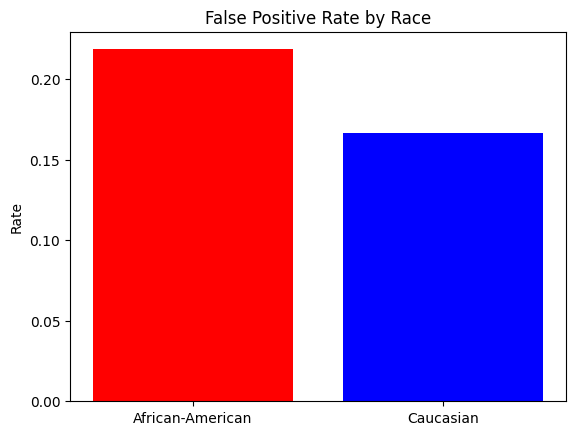

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# False Positive Rate by race
fpr_unpriv = sum((y_pred == 1) & (y_test == 0) & (X_test['race'] == 0)) / sum((y_test == 0) & (X_test['race'] == 0))
fpr_priv = sum((y_pred == 1) & (y_test == 0) & (X_test['race'] == 1)) / sum((y_test == 0) & (X_test['race'] == 1))

plt.bar(['African-American', 'Caucasian'], [fpr_unpriv, fpr_priv], color=['red', 'blue'])
plt.title('False Positive Rate by Race')
plt.ylabel('Rate')
plt.show()


In [15]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

dataset_transf = RW.fit_transform(dataset)

metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     privileged_groups=privileged_groups,
                                     unprivileged_groups=unprivileged_groups)

print("Post-Reweighing Disparate Impact:", metric_rw.disparate_impact())


Post-Reweighing Disparate Impact: 0.9999999999999998


## Summary
- African-American defendants had a higher false positive rate.
- Disparate impact < 0.8 confirms racial bias.
- Reweighing improved fairness metrics.

## Reflection
This audit highlights the ethical risks of deploying AI in criminal justice. Fairness-aware design and regular audits are essential to prevent harm and uphold trust.
